In [1]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

%load_ext autoreload

In [2]:
# load checkpoint 2 model
time = '400'
date = '2025-05-15'
experiment = 'NEW_NewGenes_checkpoint2'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [3]:
# get commonly stored variables
metabolism = agent['ecoli-metabolism-redux-classic']
stoichiometry = metabolism.stoichiometry.copy()
reaction_names = metabolism.reaction_names
fba_new_reaction_ids = metabolism.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism.parameters['fba_reaction_ids_to_base_reaction_ids']
metabolites = metabolism.metabolite_names.copy()
binary_kinetic_idx = metabolism.binary_kinetic_idx
exchange_molecules = metabolism.exchange_molecules

S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites , columns=reaction_names )
homeostatic_count = pd.DataFrame(fba["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).mean(axis=0)
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).mean(axis=0).copy()

In [4]:
# parameters that are the same across the two simulation
kinetic_reaction_ids = metabolism.kinetic_constraint_reactions
allowed_exchange_uptake = metabolism.allowed_exchange_uptake
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]
ADDED_RXNS = ['HS-TRANSPORT-RXN-CPD0-1202', 'HS-TRANSPORT-RXN-CPD0-1202 (reverse)',
                   'HS-TRANSPORT-RXN[CCO-OUTER-MEM]-OXAMATE', 'HS-TRANSPORT-RXN[CCO-OUTER-MEM]-OXAMATE (reverse)',
                   'HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE', 'HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse)',
                   'HS-BETA-GLUCURONID-RXN_CPD-3611//METOH', 'HS-SPONTANEOUS-TRANSPORT[CCO-OUTER-MEM]-HCN', 'HS-SPONTANEOUS-TRANSPORT[CCO-OUTER-MEM]-HCN (reverse)',
                   'HS-SPONTANEOUS-TRANSPORT[CCO-PM-BAC-NEG]-HCN','HS-SPONTANEOUS-TRANSPORT[CCO-PM-BAC-NEG]-HCN (reverse)']

# Define functions for testing

In [5]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

def get_keys(dict, value):
    return [key for key in dict if dict[key] == value]

def test_NetworkFlowModel(objective_weights,
                          uptake_addition = set([]), uptake_removal = set([]), new_exchange_molecules = set([]),
                          add_metabolite = None, add_reaction = None, add_kinetic = None, remove_reaction = None, force_reaction = None):
    # update exchanges
    uptake = metabolism.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | uptake_addition
    uptake = uptake - uptake_removal
    
    exchange_molecules = metabolism.exchange_molecules.copy()
    exchange_molecules = exchange_molecules | new_exchange_molecules
    
    # update stoichiometry
    reaction_names = metabolism.reaction_names.copy()
    kinetic_reaction_ids = metabolism.kinetic_constraint_reactions.copy()
    kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :].copy()
    metabolites = metabolism.metabolite_names.copy()
    
    S_new = stoichiometry.copy()
    
    if add_metabolite is not None: # add to metabolites list because they are currently not included in the model
        for m in add_metabolite:
            if m not in metabolites:
                metabolites.append(m)
        # append rows of zeros to S_new of length add_metabolite
        S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
    
    if add_reaction is not None:
        # assert add_reaction is a dictionary
        assert isinstance(add_reaction, dict)
        
        for r,s in add_reaction.items():
            if r not in reaction_names:
                reaction_names.append(r)
            # append columns of reaction stoich to S_new of length add_reaction
            new_reaction = np.zeros((S_new.shape[0], 1))
            for m, v in s.items():
                new_reaction[metabolites.index(m), 0] = v
            S_new = np.concatenate((S_new, new_reaction), axis=1)
    
    if add_kinetic is not None:
        # assert add_kinetic is a dictionary
        assert isinstance(add_kinetic, dict)
        
        for r, v in add_kinetic.items():
            if r not in kinetic_reaction_ids:
                kinetic_reaction_ids.append(r)
                kinetic[r] = v
                
    if remove_reaction is not None:
        for r in remove_reaction:
            r_idx = reaction_names.index(r)
            S_new = np.delete(S_new, r_idx, axis=1)
            reaction_names.remove(r)
            if r in kinetic_reaction_ids:
                kinetic_reaction_ids.remove(r)
                del kinetic[r]
                
    if force_reaction is not None:
        force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
    else:
        force_reaction_idx = force_reaction

    # Solve NetworkFlowModel
    model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolites,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.MOSEK) #SCS. ECOS, MOSEK
    return solution.objective, solution.velocities, reaction_names, S_new, metabolites, kinetic, solution

# Add new diversity objective

In [6]:
objectives = {
    'no change (without binary_idx)': {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.0000001}, # kinetic used in FBA 0.000001, but these numbers here are the ones used in whole-cell
    'add diversity': {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.0000001, 'diversity': 0.00001},
    'remove efficiency and add diversity': {'secretion': 0.01, 'kinetics': 0.0000001, 'diversity': 0.00001},

}

In [7]:
df_all = pd.DataFrame(fba["estimated_fluxes"], columns= reaction_names).mean(axis=0).copy()
for objective_name, weights in objectives.items():
    objective_weights = weights
    objective, solution_flux, _, _, _, kinetic, _ = test_NetworkFlowModel(objective_weights)
    print(f'The condition {objective_name} has objective value of {objective}')
    
    sim_flux = pd.DataFrame({f'{objective_name}': solution_flux}, index = reaction_names)
    df_all = pd.concat([df_all, sim_flux], axis=1)
    

/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


The condition no change (without binary_idx) has objective value of 107975.96766289239


/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


The condition add diversity has objective value of 107975.97004056483


/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/HeenaSaqib/.pyenv/versions/3.11.3/envs/viv-ecoli/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


The condition remove efficiency and add diversity has objective value of 215902.10404011453


In [8]:
df_all['kinetic'] = [kinetic[r] if r in kinetic_reaction_ids else False for r in df_all.index]
df_all['is_new'] = ['New Reactions' if r in fba_new_reaction_ids else "Old Reactions" for r in df_all.index]

# convert flux to log(flux+E-6)
df_all_log = df_all.applymap(lambda x: np.log10(x + 1e-4) if isinstance(x, (float)) else x)
df_all_log

,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
1.1.1.127-RXN,-4.000000,-4.000000,0.000043,9.000000,False,Old Reactions
1.1.1.127-RXN (reverse),-4.000000,-4.000000,0.000043,9.000000,False,Old Reactions
1.1.1.215-RXN (reverse),-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
1.1.1.251-RXN,-4.000000,-4.000000,0.000043,9.000000,False,Old Reactions
...,...,...,...,...,...,...
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
YIAE1-RXN (reverse),-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
glycogen-monomer-extension,3.954490,3.954490,3.954490,3.954490,False,Old Reactions
DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.DEPHOSICITDEHASE-RXN,-4.000000,-4.000000,0.000043,0.000043,False,Old Reactions


In [9]:
df_kinetic = df_all_log[df_all_log['kinetic'] != False]

In [10]:
sum(df_all['remove efficiency and add diversity'])

4487085744945.318

In [11]:
sum(df_all['add diversity']), sum(df_all[0]), sum(df_all['no change (without binary_idx)']) 

(20424969.914122008, 20425695.324999984, 20419280.414074536)

In [12]:
df_all_log

,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
1.1.1.127-RXN,-4.000000,-4.000000,0.000043,9.000000,False,Old Reactions
1.1.1.127-RXN (reverse),-4.000000,-4.000000,0.000043,9.000000,False,Old Reactions
1.1.1.215-RXN (reverse),-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
1.1.1.251-RXN,-4.000000,-4.000000,0.000043,9.000000,False,Old Reactions
...,...,...,...,...,...,...
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
YIAE1-RXN (reverse),-4.000000,-4.000000,-4.000000,-4.000000,False,Old Reactions
glycogen-monomer-extension,3.954490,3.954490,3.954490,3.954490,False,Old Reactions
DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.DEPHOSICITDEHASE-RXN,-4.000000,-4.000000,0.000043,0.000043,False,Old Reactions


In [13]:
# save dataframe as csv
df_all_log.to_csv('notebooks/Heena notebooks/Metabolism_New Genes/diversity_objective.csv', index=True)

In [14]:
data = df_all.copy()
data['index'] = data.index
data = data[data['is_new'].isin(['New Reactions', 'Old Reactions'])]
data

,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new,index
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN
1.1.1.127-RXN,0.000000e+00,-0.000000e+00,1.000000e+00,1.000000e+09,False,Old Reactions,1.1.1.127-RXN
1.1.1.127-RXN (reverse),0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+09,False,Old Reactions,1.1.1.127-RXN (reverse)
1.1.1.215-RXN (reverse),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,1.1.1.215-RXN (reverse)
1.1.1.251-RXN,0.000000e+00,-0.000000e+00,1.000000e+00,1.000000e+09,False,Old Reactions,1.1.1.251-RXN
...,...,...,...,...,...,...,...
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,False,Old Reactions,XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPH...
YIAE1-RXN (reverse),0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,YIAE1-RXN (reverse)
glycogen-monomer-extension,9.005122e+03,9.005120e+03,9.005120e+03,9.005120e+03,False,Old Reactions,glycogen-monomer-extension
DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.DEPHOSICITDEHASE-RXN,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,False,Old Reactions,DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MO...


In [15]:
data_kinetic = data[data['kinetic'] != False].copy()
data_melted = data_kinetic.melt(id_vars=['kinetic'],
                                value_vars=[0, 'add diversity', 'remove efficiency and add diversity'])
x_data = data_melted['kinetic']
y_data = data_melted['value']

In [16]:
data_kinetic = data[data['kinetic'].apply(lambda x: isinstance(x, float))].copy()
data_melted = data_kinetic.melt(id_vars=['kinetic'],
                                            value_vars=[0, 'add diversity', 'remove efficiency and add diversity'])
x_data = data_melted['kinetic']
y_data = data_melted['value']

In [17]:
data_melted

,kinetic,variable,value
0,15764.0,0,0.0000
1,698.0,0,0.0000
2,67.0,0,0.0000
3,90.0,0,0.0000
4,90.0,0,0.0000
...,...,...,...
1243,65.0,remove efficiency and add diversity,77.1925
1244,10.0,remove efficiency and add diversity,0.0000
1245,1327.0,remove efficiency and add diversity,1327.0000
1246,22400.0,remove efficiency and add diversity,27.7800


# Check cell growth (dry mass) for the three conditions

In [18]:
# load default model
time = '800'
date = '2025-07-09'
experiment = 'NEW_flowPartition_default'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/flow-partition/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_default = output['listeners']['fba_results']
mass_default = output['listeners']['mass']
bulk_default = pd.DataFrame(output['bulk'])


S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites, columns=reaction_names )
homeostatic_count_default = pd.DataFrame(fba_default["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
homeostatic_default = pd.DataFrame(fba_default["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
maintenance_default = pd.DataFrame(fba_default["maintenance_target"][1:], columns=['maintenance_reaction']).mean(axis=0)
kinetic_default = pd.DataFrame(fba_default["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).mean(axis=0).copy()

In [19]:
# load diversity only model
time = '800'
date = '2025-07-07'
experiment = 'NEW_flowPartition_diversity only'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/flow-partition/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_diversity_only = output['listeners']['fba_results']
mass_diversity_only = output['listeners']['mass']
bulk_diversity_only = pd.DataFrame(output['bulk'])


S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites, columns=reaction_names )
homeostatic_count_diversity_only = pd.DataFrame(fba_diversity_only["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
homeostatic_diversity_only = pd.DataFrame(fba_diversity_only["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
maintenance_diversity_only = pd.DataFrame(fba_diversity_only["maintenance_target"][1:], columns=['maintenance_reaction']).mean(axis=0)
kinetic_diversity_only = pd.DataFrame(fba_diversity_only["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).mean(axis=0).copy()

In [20]:
# load efficiency+diversity model
time = '800'
date = '2025-07-07'
experiment = 'NEW_flowPartition_efficiency+diversity'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/flow-partition/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_both = output['listeners']['fba_results']
mass_both = output['listeners']['mass']
bulk_both = pd.DataFrame(output['bulk'])

S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites, columns=reaction_names )
homeostatic_count_both = pd.DataFrame(fba_both["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
homeostatic_both = pd.DataFrame(fba_both["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).mean(axis=0)
maintenance_both = pd.DataFrame(fba_both["maintenance_target"][1:], columns=['maintenance_reaction']).mean(axis=0)
kinetic_both = pd.DataFrame(fba_both["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).mean(axis=0).copy()

In [21]:
# load efficiency+diversity model
time = '400'
date = '2025-05-15'
experiment = 'NEW_MOSEK'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_MOSEK = output['listeners']['fba_results']

In [22]:
import math
def loop_plot(keys):
    
    fig, axs = plt.subplots(math.ceil(len(keys)/2), 2, figsize = (10,6))
    for idx,key in enumerate(keys):
        xx = np.asarray(mass_default[key])
        xx2 = mass_diversity_only[key]
        xx3 = mass_both[key]
        tt = np.arange(0,len(xx),1)

        row = int(math.floor(idx/2))
        col = idx % 2
        axs[row, col].plot(tt,xx, '_', label = 'Default (Efficiency Only)')
        axs[row, col].plot(tt,xx2, '-', label = 'Diversity Only')
        axs[row, col].plot(tt,xx3, '--', label = 'Efficiency and Diversity')
        axs[row, col].set_ylabel(key)
        axs[row, col].set_xlabel('Time (s)')
    axs[row, col].legend()
    return fig, axs

In [23]:
mass.keys()

dict_keys(['cell_mass', 'water_mass', 'dry_mass', 'rna_mass', 'rRna_mass', 'tRna_mass', 'mRna_mass', 'dna_mass', 'protein_mass', 'smallMolecule_mass', 'volume', 'protein_mass_fraction', 'rna_mass_fraction', 'growth', 'instantaneous_growth_rate', 'dry_mass_fold_change', 'protein_mass_fold_change', 'rna_mass_fold_change', 'small_molecule_fold_change', 'projection_mass', 'cytosol_mass', 'extracellular_mass', 'flagellum_mass', 'membrane_mass', 'outer_membrane_mass', 'periplasm_mass', 'pilus_mass', 'inner_membrane_mass', 'expected_mass_fold_change'])

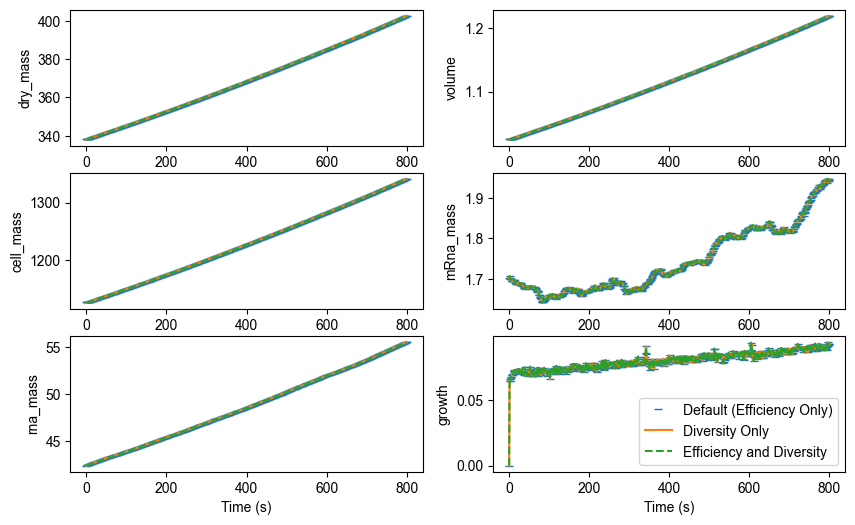

In [62]:
plot_items = ['dry_mass', 'volume', 'cell_mass', 'mRna_mass', 'rna_mass', 'growth']
figs, axs = loop_plot(plot_items)
figs

# gene usage for the most extreme case

In [25]:
df_all['default MOSEK'] = pd.DataFrame(fba_MOSEK["estimated_fluxes"], columns= reaction_names).mean(axis=0).copy()

In [26]:
print(f'Number of reactions used, out of {len(df_all)} total reactions, in the default wc-model is {len(df_all[df_all[0] != 0])}')
print(f'Number of reactions used, out of {len(df_all)} total reactions, in the default wc-model (MOSEK) is {len(df_all[df_all["default MOSEK"] != 0])}')
print(f'Number of reactions used, out of {len(df_all)} total reactions, in the default objective weights FBA is {len(df_all[df_all["no change (without binary_idx)"] != 0])}')
print(f'Number of reactions used, out of {len(df_all)} total reactions, in the model with added diversity objective is {len(df_all[df_all["add diversity"] != 0])}')
print(f'Number of reactions used, out of {len(df_all)} total reactions, in the model with diversity only objective is {len(df_all[df_all["remove efficiency and add diversity"] != 0])}')


Number of reactions used, out of 9372 total reactions, in the default wc-model is 416
Number of reactions used, out of 9372 total reactions, in the default wc-model (MOSEK) is 1824
Number of reactions used, out of 9372 total reactions, in the default objective weights FBA is 2385
Number of reactions used, out of 9372 total reactions, in the model with added diversity objective is 5885
Number of reactions used, out of 9372 total reactions, in the model with diversity only objective is 5817


<span style="background-color:#FA8072; color:black;">The most extreme case is, therefore, efficiency and diversity </span>

In [27]:
%store -r df_all_gene_usage genes_to_enzymes new_genes

In [ ]:
# %store df_all_gene_usage_basal_with_diversity

In [29]:
conditions = ['default MOSEK', 'add diversity']
condition_all = ['basal'] + conditions
reaction_catalysts = metabolism.parameters["reaction_catalysts"]

df_most_extreme_all_gene_usage = df_all_gene_usage.copy()
for condition in conditions:
    df_most_extreme_all_gene_usage[condition] = 0
    for rxn in reaction_names:
        is_used = df_all.loc[rxn, condition]
        enzymes = reaction_catalysts.get(rxn,[])
        for enz in enzymes:
            enz = enz[:-3]
            genes = get_keys(genes_to_enzymes, enz)
            for gene in genes:
                if is_used:
                    df_most_extreme_all_gene_usage.loc[gene, condition] += 1
                if rxn in kinetic_reaction_ids:
                    df_most_extreme_all_gene_usage.loc[gene, 'has_kinetic'] = True


# tally usage
df_most_extreme_all_gene_usage['is_used'] = np.any(df_most_extreme_all_gene_usage[conditions] > 0, axis=1)
df_most_extreme_all_gene_usage = df_most_extreme_all_gene_usage.drop(['acetate', 'rich','anaerobic_basal','anaerobic_acetate', 'anaerobic_rich'], axis=1)

## Plot 1: Gene Usage Histogram for adding diversity objective

In [30]:
df_most_extreme_all_gene_usage

,Enzyme encoded,Reactions,has_kinetic,basal,is_used,default MOSEK,add diversity
Gene ID (EcoCyc),,,,,,,
EG11679,AAS-MONOMER,"[ACYLGPEACYLTRANS-RXN, RXN-5741, RXN0-5513]",False,0,True,0,2
EG11647,ACETYL-COA-CARBOXYLTRANSFER-CPLX,[RXN0-5055],False,1,True,1,1
EG10276,BIOTIN-CARBOXYL-CPLX,[BIOTIN-CARBOXYL-RXN],True,1,True,1,1
EG10217,ACETYL-COA-CARBOXYLTRANSFER-CPLX,[RXN0-5055],False,1,True,1,1
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,True,2,2
...,...,...,...,...,...,...,...
EG12215,YHHO-MONOMER,"[RXN0-5205, 3.6.3.3-RXN, TRANS-RXN-452]",False,0,True,2,0
G7017,ABC-63-CPLX,[ABC-63-RXN],False,0,False,0,0
G7018,ABC-63-CPLX,[ABC-63-RXN],False,0,False,0,0


In [33]:
%store -r df_all_gene_usage
# % new gene usage
df_gene_usage = df_all_gene_usage.loc[new_genes,:]
df_most_extreme_gene_usage = df_most_extreme_all_gene_usage.loc[new_genes,:]

num_genes = len(df_gene_usage)
perc_gene_usage_basal        = sum(df_gene_usage.basal > 0)/num_genes * 100
perc_gene_usage_w_diversity  = sum(df_most_extreme_gene_usage['add diversity'] > 0)/num_genes * 100
perc_gene_usage_w_MOSEK      = sum(df_most_extreme_gene_usage['default MOSEK'] > 0 )/num_genes * 100

perc = [perc_gene_usage_basal, perc_gene_usage_w_diversity, perc_gene_usage_w_MOSEK] 
x_label = ['Basal', 'Basal with Diversity Objective', 'Basal using MOSEK']

In [34]:
# % all gene usage
num_genes = len(df_all_gene_usage)
perc_all_gene_usage_basal = sum(df_all_gene_usage.basal > 0)/num_genes * 100
perc_all_gene_usage_w_diversity = sum(df_most_extreme_all_gene_usage['add diversity'] > 0)/num_genes * 100
perc_all_gene_usage_w_MOSEK = sum(df_most_extreme_all_gene_usage['default MOSEK'] > 0)/num_genes * 100


perc_all = [perc_all_gene_usage_basal, perc_all_gene_usage_w_diversity, perc_all_gene_usage_w_MOSEK]

%store  perc_gene_usage_w_MOSEK perc_all_gene_usage_w_MOSEK

Stored 'perc_gene_usage_w_MOSEK' (float)
Stored 'perc_all_gene_usage_w_MOSEK' (float)


In [35]:
# Create a DataFrame
df = pd.DataFrame({
    "Condition": x_label,
    "New Metabolic Gene": perc,
    "All Metabolic Gene": perc_all,
})

# Reshape to long format
df_long = df.melt(id_vars="Condition", 
                  value_vars=["New Metabolic Gene", "All Metabolic Gene"],
                  var_name="Gene Group",
                  value_name="Percent Usage")

# Create grouped bar plot
fig = px.bar(
    df_long,
    x="Condition",
    y="Percent Usage",
    color="Gene Group",              # creates a legend
    barmode="group",                 # side-by-side bars
    text="Percent Usage",
    title="New vs All Metabolic Gene Usage by Condition",
    labels={"Percent Usage": "Percent gene usage (%)"},
    color_discrete_map={
        "New Metabolic Gene": "#4C78A8",
        "All Metabolic Gene": "#c26426"
    }
)

# Customize appearance
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    yaxis_title="Percent gene usage (%)",
    # yaxis=dict(range=[0, 60]),
    xaxis_title=None,
    xaxis_tickangle=-35,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    margin=dict(t=50, b=50, l=50, r=50),
    width=800,   # width in pixels
    height=500
)

fig.show(renderer='browser')
# save 
# fig.write_image("notebooks/Heena notebooks/Metabolism_New Genes/out/gene_usage_histogram_cp3.png", scale=5, width=800, height=500)

In [36]:
df_most_extreme_gene_usage

,Enzyme encoded,Reactions,has_kinetic,basal,is_used,default MOSEK,add diversity
Gene ID (EcoCyc),,,,,,,
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,True,2,2
EG10023,MALATE-SYNTHASE,[MALSYN-RXN],False,1,True,1,1
EG11942,CPLX0-7955,"[RXN0-1981, RXN0-5111, TRANS-RXN0-576]",False,0,True,1,1
EG11724,EG11724-MONOMER,[TRANS-RXN0-447],False,0,False,0,0
EG12462,CPLX0-7535,[RXN0-2162],False,0,False,0,0
...,...,...,...,...,...,...,...
G7248,CPLX0-8290,[RXN0-5052],False,0,False,0,0
G7408,G7408-MONOMER,[RXN0-5186],True,0,False,0,0
EG12517,ABC-46-CPLX,"[TRANS-RXN0-492, TRANS-RXN0-491]",False,0,False,0,0


In [38]:
df_most_extreme_gene_usage.to_csv('notebooks/Heena notebooks/Metabolism_New Genes/MOSEK_Basal_new_gene_usage.csv', index=True)

# Investigate energy using and generating equations. Focus on ATP for now. 

In [41]:
met_of_interest = ['ATP[c]']
S_met, ATP_rxns  = get_subset_S(S, met_of_interest)  
rxn_flux = df_all.loc[ATP_rxns]
rxn_flux['consume or produce'] = ['consume' if entry < 0 else 'produce' for entry in S_met.loc['ATP[c]']] #if S_met entry is positive, then produce, if not, then consume
rxn_flux

,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new,default MOSEK,consume or produce
1PFRUCTPHOSN-RXN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,False,New Reactions,0.000000e+00,consume
2.7.1.148-RXN,3.711275e+02,3.710425e+02,3.710425e+02,3.710425e+02,False,Old Reactions,3.712800e+02,consume
2.7.10.1-RXN,0.000000e+00,9.109118e-31,0.000000e+00,0.000000e+00,False,Old Reactions,2.500000e-03,consume
2.7.13.1-RXN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume
2.7.13.2-RXN,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume
...,...,...,...,...,...,...,...,...
UDPKIN-RXN,2.379867e+04,2.379864e+04,2.379864e+04,2.379864e+04,False,Old Reactions,2.379906e+04,consume
UHPB-RXN,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume
URIDINEKIN-RXN,0.000000e+00,9.109118e-31,0.000000e+00,0.000000e+00,False,Old Reactions,8.500000e-02,consume
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume


In [54]:
# find biggest energy generating reaction
temp = rxn_flux[rxn_flux['consume or produce'] == 'produce']
print(sum(temp[0]))
temp

2980281.6900000004


,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new,default MOSEK,consume or produce
ACETATEKIN-RXN (reverse),0.000000e+00,1.053205e-27,1.000000e+00,9.999800e+08,False,Old Reactions,1.040250e+01,produce
ADENYL-KIN-RXN (reverse),0.000000e+00,1.053205e-27,1.000000e+00,1.000000e+09,False,Old Reactions,8.332500e+00,produce
ATPPHOSPHORIBOSYLTRANS-RXN,0.000000e+00,-0.000000e+00,1.000000e+00,9.999960e+08,False,Old Reactions,4.772500e+00,produce
ATPSYN-RXN (reverse),2.257474e+06,2.257472e+06,2.257474e+06,2.734195e+06,14242.0,Old Reactions,2.257558e+06,produce
GMKALT-RXN (reverse),7.085000e+00,6.987500e+00,7.987500e+00,1.000000e+09,False,Old Reactions,1.423750e+01,produce
GUANYL-KIN-RXN (reverse),0.000000e+00,1.053205e-27,1.000000e+00,9.999844e+08,False,Old Reactions,5.045000e+00,produce
PEPDEPHOS-RXN (reverse),9.928750e+02,3.731269e-02,1.000000e+00,1.000000e+00,False,Old Reactions,1.417368e+03,produce
PHOSGLYPHOS-RXN (reverse),6.041527e+05,6.041522e+05,6.041532e+05,6.041532e+05,False,Old Reactions,6.041984e+05,produce
PROPKIN-RXN (reverse),0.000000e+00,3.550786e-27,2.000000e+00,1.000000e+09,False,Old Reactions,1.251250e+01,produce
RXN-11832 (reverse),0.000000e+00,1.108637e-27,1.000000e+00,1.445144e+04,False,Old Reactions,5.585000e+00,produce


In [55]:
# find biggest energy consuming reaction
temp = rxn_flux[rxn_flux['consume or produce'] == 'consume']
print(sum(temp[0]))
temp


2929166.7375000003


,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new,default MOSEK,consume or produce
1PFRUCTPHOSN-RXN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,False,New Reactions,0.000000e+00,consume
2.7.1.148-RXN,3.711275e+02,3.710425e+02,3.710425e+02,3.710425e+02,False,Old Reactions,3.712800e+02,consume
2.7.10.1-RXN,0.000000e+00,9.109118e-31,0.000000e+00,0.000000e+00,False,Old Reactions,2.500000e-03,consume
2.7.13.1-RXN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume
2.7.13.2-RXN,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume
...,...,...,...,...,...,...,...,...
UDPKIN-RXN,2.379867e+04,2.379864e+04,2.379864e+04,2.379864e+04,False,Old Reactions,2.379906e+04,consume
UHPB-RXN,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume
URIDINEKIN-RXN,0.000000e+00,9.109118e-31,0.000000e+00,0.000000e+00,False,Old Reactions,8.500000e-02,consume
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,False,Old Reactions,0.000000e+00,consume


In [53]:
S.loc[:,'maintenance_reaction']

1-2-Diglycerides[c]                         0
1-AMINO-PROPAN-2-ONE-3-PHOSPHATE[c]         0
1-Cys-Peroxiredoxin-L-cysteine[c]           0
1-Cys-Peroxiredoxin-L-hydroxycysteine[c]    0
1-KETO-2-METHYLVALERATE[c]                  0
                                           ..
tRNAs-with-glutamylated-queuosine[c]        0
tRNAs-with-queuine[c]                       0
tRNAs[c]                                    0
trans-delta2-arachidoyl-ACPs[c]             0
type-IV-prepillin[c]                        0
Name: maintenance_reaction, Length: 6078, dtype: int8

In [34]:
np.sum(rxn_flux[rxn_flux['consume or produce'] == 'produce']['add diversity']) - np.sum(rxn_flux[rxn_flux['consume or produce'] == 'consume']['add diversity'])

51111.96433496522

In [35]:
np.sum(rxn_flux[rxn_flux['consume or produce'] == 'produce']['remove efficiency and add diversity']) - np.sum(rxn_flux[rxn_flux['consume or produce'] == 'consume']['remove efficiency and add diversity'])

51052.515001297

In [36]:
rxn_flux[rxn_flux['consume or produce'] == 'produce'][0]

ACETATEKIN-RXN (reverse)      0.000000e+00
ADENYL-KIN-RXN (reverse)      0.000000e+00
ATPPHOSPHORIBOSYLTRANS-RXN    0.000000e+00
ATPSYN-RXN (reverse)          2.257474e+06
GMKALT-RXN (reverse)          7.085000e+00
GUANYL-KIN-RXN (reverse)      0.000000e+00
PEPDEPHOS-RXN (reverse)       9.928750e+02
PHOSGLYPHOS-RXN (reverse)     6.041527e+05
PROPKIN-RXN (reverse)         0.000000e+00
RXN-11832 (reverse)           0.000000e+00
RXN-14196 (reverse)           0.000000e+00
RXN-14569 (reverse)           0.000000e+00
RXN-17190 (reverse)           0.000000e+00
RXN-9376 (reverse)            0.000000e+00
RXN0-1401 (reverse)           0.000000e+00
SUCCCOASYN-RXN (reverse)      1.176553e+05
TRANS-RXN0-162 (reverse)      0.000000e+00
Name: 0, dtype: float64

In [40]:
S_met

NameError: name 'S_met' is not defined

In [60]:
df_all.loc[['PHOSACETYLTRANS-RXN__CPLX0-7912', 'CITSYN-RXN'],:]

,0,no change (without binary_idx),add diversity,remove efficiency and add diversity,kinetic,is_new,default MOSEK
PHOSACETYLTRANS-RXN__CPLX0-7912,0.00,2.364899e-27,1.000000,1350.000000,1350.0,Old Reactions,11.9275
CITSYN-RXN,212595.57,2.125954e+05,212595.438824,212595.438919,2272.0,Old Reactions,212564.0450


In [58]:
for rxn in reaction_names:
    if 'PHOSACETYLTRANS' in rxn:
        print(rxn)

PHOSACETYLTRANS-RXN__CPLX0-7912
PHOSACETYLTRANS-RXN__CPLX0-7912 (reverse)
PHOSACETYLTRANS-RXN__PHOSACETYLTRANS-CPLX
PHOSACETYLTRANS-RXN__PHOSACETYLTRANS-CPLX (reverse)
